In [1]:
import os
import json
import random
from pathlib import Path


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
plt.style.use('default')  
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14


In [4]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers


In [5]:
# --- Cell 1: Setup and Imports ---
import os
import json
import random
import warnings
from pathlib import Path
from datetime import datetime


warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2


plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10


print(f"TensorFlow Version: {tf.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")


gpus = tf.config.list_physical_devices('GPU')
print(f"\nGPU Available: {len(gpus) > 0}")
if gpus:
    print(f"GPU Device: {tf.test.gpu_device_name()}")
    for gpu in gpus:
        print(f"GPU Details: {tf.config.experimental.get_device_details(gpu)}")

def set_seed(seed=42):
    """Set random seed for reproducibility"""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    if gpus:
        tf.config.experimental.enable_op_determinism()

set_seed(42)


def create_directories():
    """Create necessary directories if they don't exist"""
    dirs = [
        'data/processed',
        'models',
        'reports/figures',
        'reports/metrics'
    ]
    
    for dir_path in dirs:
        Path(dir_path).mkdir(parents=True, exist_ok=True)
        print(f"Created directory: {dir_path}")

create_directories()

print("\nEnvironment setup complete! Ready to proceed with data loading and preprocessing.")

TensorFlow Version: 2.16.2
NumPy Version: 1.26.4
Pandas Version: 2.3.1

GPU Available: True
GPU Device: /device:GPU:0
GPU Details: {'device_name': 'METAL'}
Created directory: data/processed
Created directory: models
Created directory: reports/figures
Created directory: reports/metrics

Environment setup complete! Ready to proceed with data loading and preprocessing.


Verifying paths...
BASE_DIR exists: True
DATA_DIR exists: True
POSITIVE_DIR exists: True
NEGATIVE_DIR exists: True

Found 422 positive images
Found 147 negative images

Sample files found:
Positive: ['63.jpg', '189.jpg', '77.jpg']
Negative: ['63.jpg', '77.jpg', '88.jpg']

Class distribution:
label
Positive    422
Negative    147
Name: count, dtype: int64


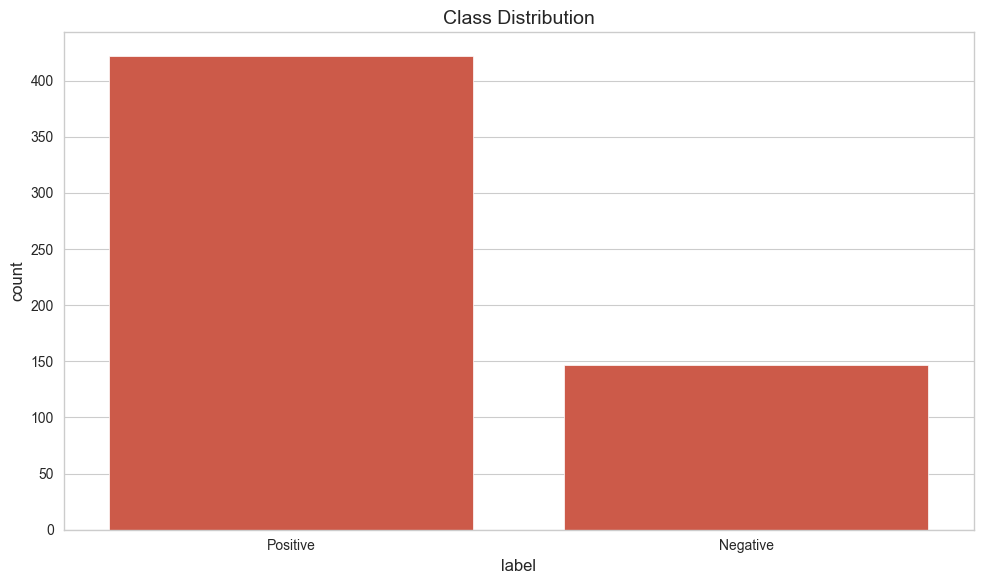


Dataset split:
Training samples: 398
Validation samples: 85
Test samples: 86
Found 398 validated image filenames belonging to 2 classes.
Found 85 validated image filenames belonging to 2 classes.
Found 86 validated image filenames belonging to 2 classes.

Sample training images:


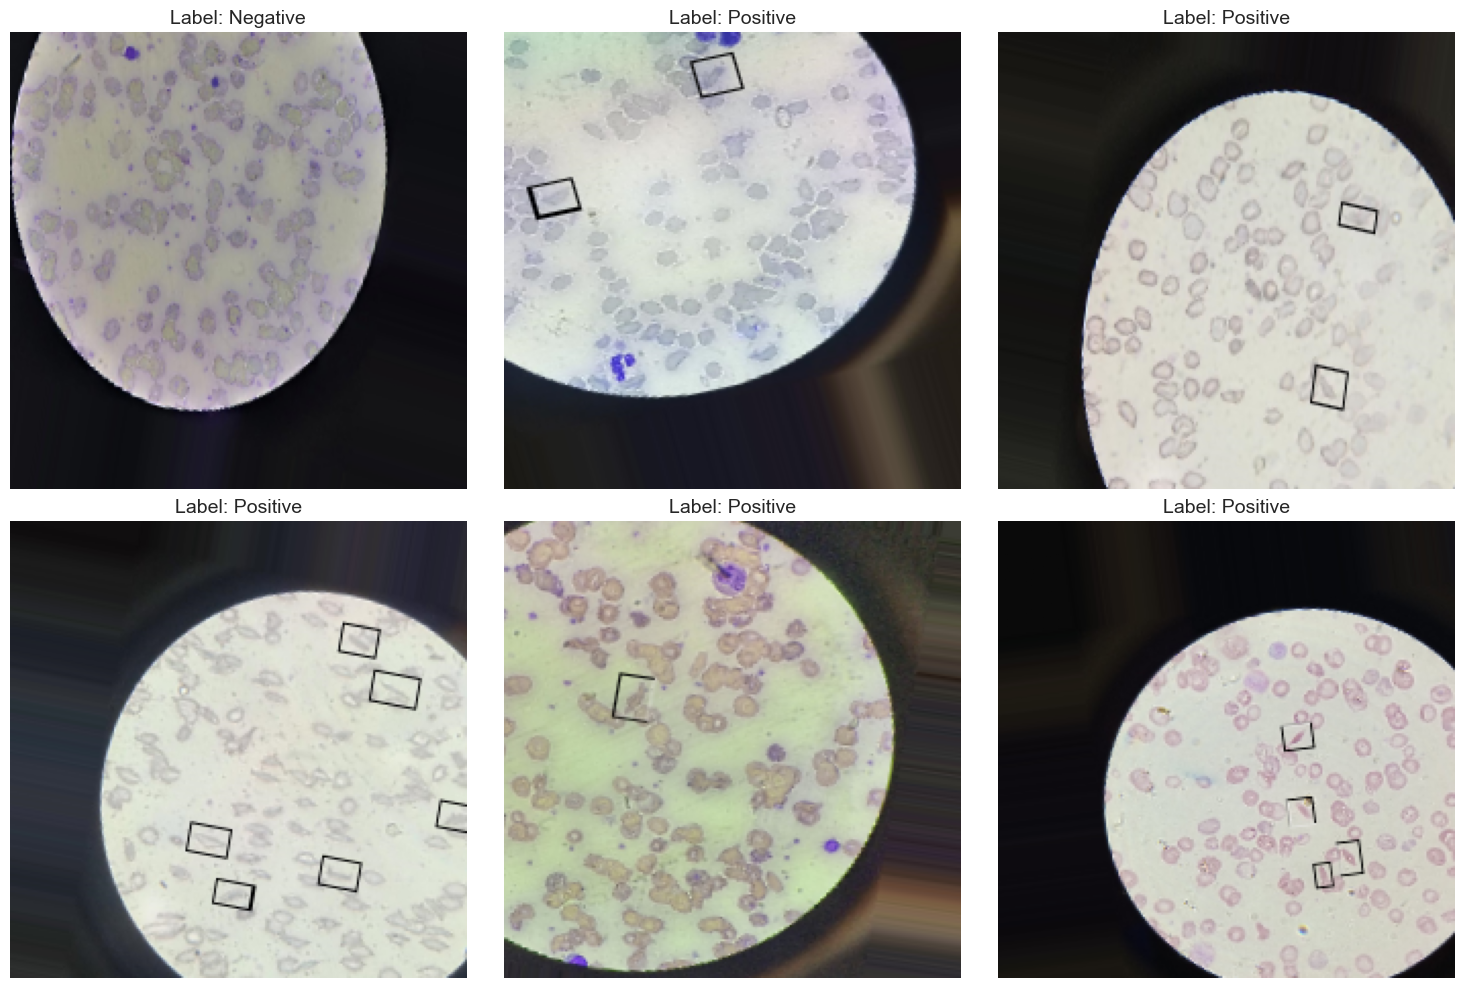


Data loading and preprocessing complete!
Class indices: {'Negative': 0, 'Positive': 1}


In [6]:
# --- Cell 2: Data Loading and Preprocessing ---

# Define base paths
BASE_DIR = Path("/Applications/Projects/Sickle Cell Classifer")
DATA_DIR = BASE_DIR / 'Data'  # Note: 'Data' with capital D based on your structure
POSITIVE_DIR = DATA_DIR / 'Positive' / 'Labelled'
NEGATIVE_DIR = DATA_DIR / 'Negative' / 'Clear'  # Note: 'Clear' instead of 'Labelled' for negative


REPORTS_DIR = BASE_DIR / 'reports' / 'figures'
REPORTS_DIR.mkdir(parents=True, exist_ok=True)


print("Verifying paths...")
print(f"BASE_DIR exists: {BASE_DIR.exists()}")
print(f"DATA_DIR exists: {DATA_DIR.exists()}")
print(f"POSITIVE_DIR exists: {POSITIVE_DIR.exists()}")
print(f"NEGATIVE_DIR exists: {NEGATIVE_DIR.exists()}")


try:
    pos_images = list(POSITIVE_DIR.glob('*.jpg')) + list(POSITIVE_DIR.glob('*.jpeg')) + list(POSITIVE_DIR.glob('*.png'))
    neg_images = list(NEGATIVE_DIR.glob('*.jpg')) + list(NEGATIVE_DIR.glob('*.jpeg')) + list(NEGATIVE_DIR.glob('*.png'))
    
    print(f"\nFound {len(pos_images)} positive images")
    print(f"Found {len(neg_images)} negative images")
    
    if len(pos_images) == 0 and len(neg_images) == 0:
        print("\nNo images found. Please check:")
        print(f"1. The directory structure is correct")
        print(f"2. Images have .jpg/.jpeg/.png extensions")
        print(f"3. Files are not hidden or in subdirectories")
    else:
        print("\nSample files found:")
        print(f"Positive: {[p.name for p in pos_images[:3]]}")
        print(f"Negative: {[p.name for p in neg_images[:3]]}")
        
       
        data = {
            'image_path': [str(p) for p in pos_images + neg_images],
            'label': ['Positive'] * len(pos_images) + ['Negative'] * len(neg_images)
        }
        df = pd.DataFrame(data)
        
       
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        
        print("\nClass distribution:")
        print(df['label'].value_counts())
        
       
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x='label')
        plt.title('Class Distribution')
        plt.tight_layout()
        plt.savefig(REPORTS_DIR / 'class_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        
       
        train_df, temp_df = train_test_split(
            df, 
            test_size=0.3, 
            random_state=42,
            stratify=df['label']
        )
        
        val_df, test_df = train_test_split(
            temp_df,
            test_size=0.5,
            random_state=42,
            stratify=temp_df['label']
        )
        
        print(f"\nDataset split:")
        print(f"Training samples: {len(train_df)}")
        print(f"Validation samples: {len(val_df)}")
        print(f"Test samples: {len(test_df)}")
        
        
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        
        
        test_datagen = ImageDataGenerator(rescale=1./255)
        
        def create_generator(datagen, df, batch_size=32, shuffle=True):
            return datagen.flow_from_dataframe(
                df,
                x_col='image_path',
                y_col='label',
                target_size=(224, 224),
                batch_size=batch_size,
                class_mode='binary',
                shuffle=shuffle,
                seed=42
            )
        
        # Create data generators
        train_generator = create_generator(train_datagen, train_df)
        val_generator = create_generator(test_datagen, val_df, shuffle=False)
        test_generator = create_generator(test_datagen, test_df, shuffle=False)
        
    
        def plot_sample_images(generator, num_images=6):
            x_batch, y_batch = next(generator)
            class_names = {0: 'Negative', 1: 'Positive'}
            
            plt.figure(figsize=(15, 10))
            for i in range(min(num_images, len(x_batch))):
                plt.subplot(2, 3, i+1)
                plt.imshow(x_batch[i])
                plt.title(f"Label: {class_names[y_batch[i]]}")
                plt.axis('off')
            plt.tight_layout()
            plt.savefig(REPORTS_DIR / 'sample_images.png', dpi=300, bbox_inches='tight')
            plt.show()
        
        print("\nSample training images:")
        plot_sample_images(train_generator)
        
    
        class_indices = train_generator.class_indices
        with open(BASE_DIR / 'reports' / 'class_indices.json', 'w') as f:
            json.dump(class_indices, f)
        
        print("\nData loading and preprocessing complete!")
        print(f"Class indices: {class_indices}")
        
except Exception as e:
    print(f"\nError: {str(e)}")
    print("\nPlease check the directory structure and file paths.")
    print(f"Current working directory: {Path.cwd()}")
    print(f"DATA_DIR contents: {[p.name for p in DATA_DIR.glob('*')]}")

In [ ]:
# --- Cell 2.5: Data Loading and Preparation (Complete) ---
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


BASE_DIR = Path("/Applications/Projects/Sickle Cell Classifer")
DATA_DIR = BASE_DIR / 'Data'  
POSITIVE_DIR = DATA_DIR / 'Positive' / 'Labelled'
NEGATIVE_DIR = DATA_DIR / 'Negative' / 'Clear'


REPORTS_DIR = BASE_DIR / 'reports' / 'figures'
REPORTS_DIR.mkdir(parents=True, exist_ok=True)


print("Verifying paths...")
print(f"BASE_DIR: {BASE_DIR} (exists: {BASE_DIR.exists()})")
print(f"DATA_DIR: {DATA_DIR} (exists: {DATA_DIR.exists()})")
print(f"POSITIVE_DIR: {POSITIVE_DIR} (exists: {POSITIVE_DIR.exists()})")
print(f"NEGATIVE_DIR: {NEGATIVE_DIR} (exists: {NEGATIVE_DIR.exists()})")


print("\nLoading images...")
pos_images = list(POSITIVE_DIR.glob('*.jpg')) + list(POSITIVE_DIR.glob('*.jpeg')) + list(POSITIVE_DIR.glob('*.png'))
neg_images = list(NEGATIVE_DIR.glob('*.jpg')) + list(NEGATIVE_DIR.glob('*.jpeg')) + list(NEGATIVE_DIR.glob('*.png'))

print(f"Found {len(pos_images)} positive images")
print(f"Found {len(neg_images)} negative images")

data = {
    'image_path': [str(p) for p in pos_images + neg_images],
    'label': ['Positive'] * len(pos_images) + ['Negative'] * len(neg_images)
}
df = pd.DataFrame(data)


df = df.sample(frac=1, random_state=42).reset_index(drop=True)


print("\nSplitting data...")
train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    random_state=42,
    stratify=df['label']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)

def create_generator(datagen, df, batch_size=32, shuffle=True):
    return datagen.flow_from_dataframe(
        df,
        x_col='image_path',
        y_col='label',
        target_size=(224, 224),  
        batch_size=batch_size,
        class_mode='binary',
        shuffle=shuffle,
        seed=42
    )

#
print("\nCreating data generators...")
train_generator = create_generator(train_datagen, train_df)
val_generator = create_generator(test_datagen, val_df, shuffle=False)
test_generator = create_generator(test_datagen, test_df, shuffle=False)

print("\nData loading and preparation complete!")
print("Available variables:")
print("- train_df, val_df, test_df: DataFrames with image paths and labels")
print("- train_generator, val_generator, test_generator: Data generators for model training")

Verifying paths...
BASE_DIR: /Applications/Projects/Sickle Cell Classifer (exists: True)
DATA_DIR: /Applications/Projects/Sickle Cell Classifer/Data (exists: True)
POSITIVE_DIR: /Applications/Projects/Sickle Cell Classifer/Data/Positive/Labelled (exists: True)
NEGATIVE_DIR: /Applications/Projects/Sickle Cell Classifer/Data/Negative/Clear (exists: True)

Loading images...
Found 422 positive images
Found 147 negative images

Splitting data...
Training samples: 398
Validation samples: 85
Test samples: 86

Creating data generators...
Found 398 validated image filenames belonging to 2 classes.
Found 85 validated image filenames belonging to 2 classes.
Found 86 validated image filenames belonging to 2 classes.

Data loading and preparation complete!
Available variables:
- train_df, val_df, test_df: DataFrames with image paths and labels
- train_generator, val_generator, test_generator: Data generators for model training


In [ ]:
# --- Cell 3.0: Verify Data Loading ---
print("Verifying data loading...")


if 'train_df' not in locals():
    print("train_df not found. Running data loading code...")
    
  
    pos_images = list(POSITIVE_DIR.glob('*.jpg')) + list(POSITIVE_DIR.glob('*.jpeg')) + list(POSITIVE_DIR.glob('*.png'))
    neg_images = list(NEGATIVE_DIR.glob('*.jpg')) + list(NEGATIVE_DIR.glob('*.jpeg')) + list(NEGATIVE_DIR.glob('*.png'))
    
    data = {
        'image_path': [str(p) for p in pos_images + neg_images],
        'label': ['Positive'] * len(pos_images) + ['Negative'] * len(neg_images)
    }
    df = pd.DataFrame(data)
    
  
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    
    train_df, temp_df = train_test_split(
        df, 
        test_size=0.3, 
        random_state=42,
        stratify=df['label']
    )
    
    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.5,
        random_state=42,
        stratify=temp_df['label']
    )
    
    print("DataFrames created successfully!")
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")
    
    
    if 'train_generator' not in locals():
        
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        
        
        test_datagen = ImageDataGenerator(rescale=1./255)
        
        def create_generator(datagen, df, batch_size=32, shuffle=True):
            return datagen.flow_from_dataframe(
                df,
                x_col='image_path',
                y_col='label',
                target_size=(IMG_HEIGHT, IMG_WIDTH),
                batch_size=batch_size,
                class_mode='binary',
                shuffle=shuffle,
                seed=42
            )
        
       
        train_generator = create_generator(train_datagen, train_df)
        val_generator = create_generator(test_datagen, val_df, shuffle=False)
        test_generator = create_generator(test_datagen, test_df, shuffle=False)
        
        print("Data generators created successfully!")
else:
    print("train_df already exists. Proceeding with existing data...")


print("\nVerifying required variables:")
print(f"train_df: {'Exists' if 'train_df' in locals() else 'Missing'}")
print(f"val_df: {'Exists' if 'val_df' in locals() else 'Missing'}")
print(f"test_df: {'Exists' if 'test_df' in locals() else 'Missing'}")
print(f"train_generator: {'Exists' if 'train_generator' in locals() else 'Missing'}")
print(f"val_generator: {'Exists' if 'val_generator' in locals() else 'Missing'}")
print(f"test_generator: {'Exists' if 'test_generator' in locals() else 'Missing'}")

Verifying data loading...
train_df already exists. Proceeding with existing data...

Verifying required variables:
train_df: Exists
val_df: Exists
test_df: Exists
train_generator: Exists
val_generator: Exists
test_generator: Exists


In [ ]:
# --- Cell 3.1: Configuration and Class Weights ---
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

IMG_HEIGHT, IMG_WIDTH = 224, 224
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
NUM_CLASSES = 1  
BATCH_SIZE = 32
EPOCHS = 50


y_train = train_df['label'].map({'Positive': 1, 'Negative': 0})
class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(y_train), 
                                   y=y_train)
class_weights = dict(enumerate(class_weights))
print(f"Class weights: {class_weights}")

Class weights: {0: 1.9320388349514563, 1: 0.6745762711864407}


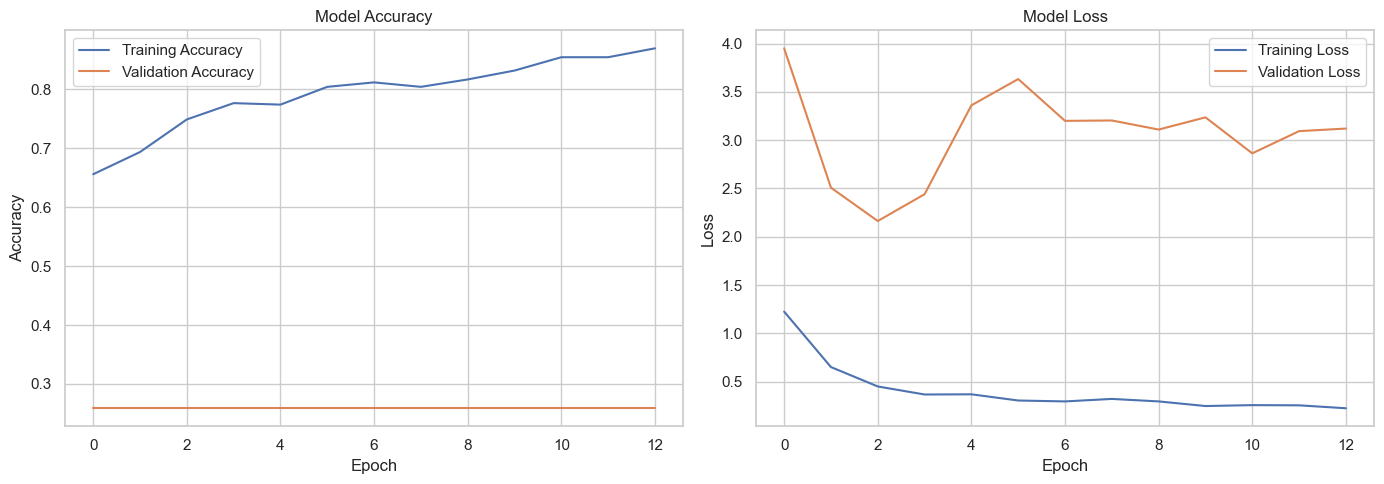

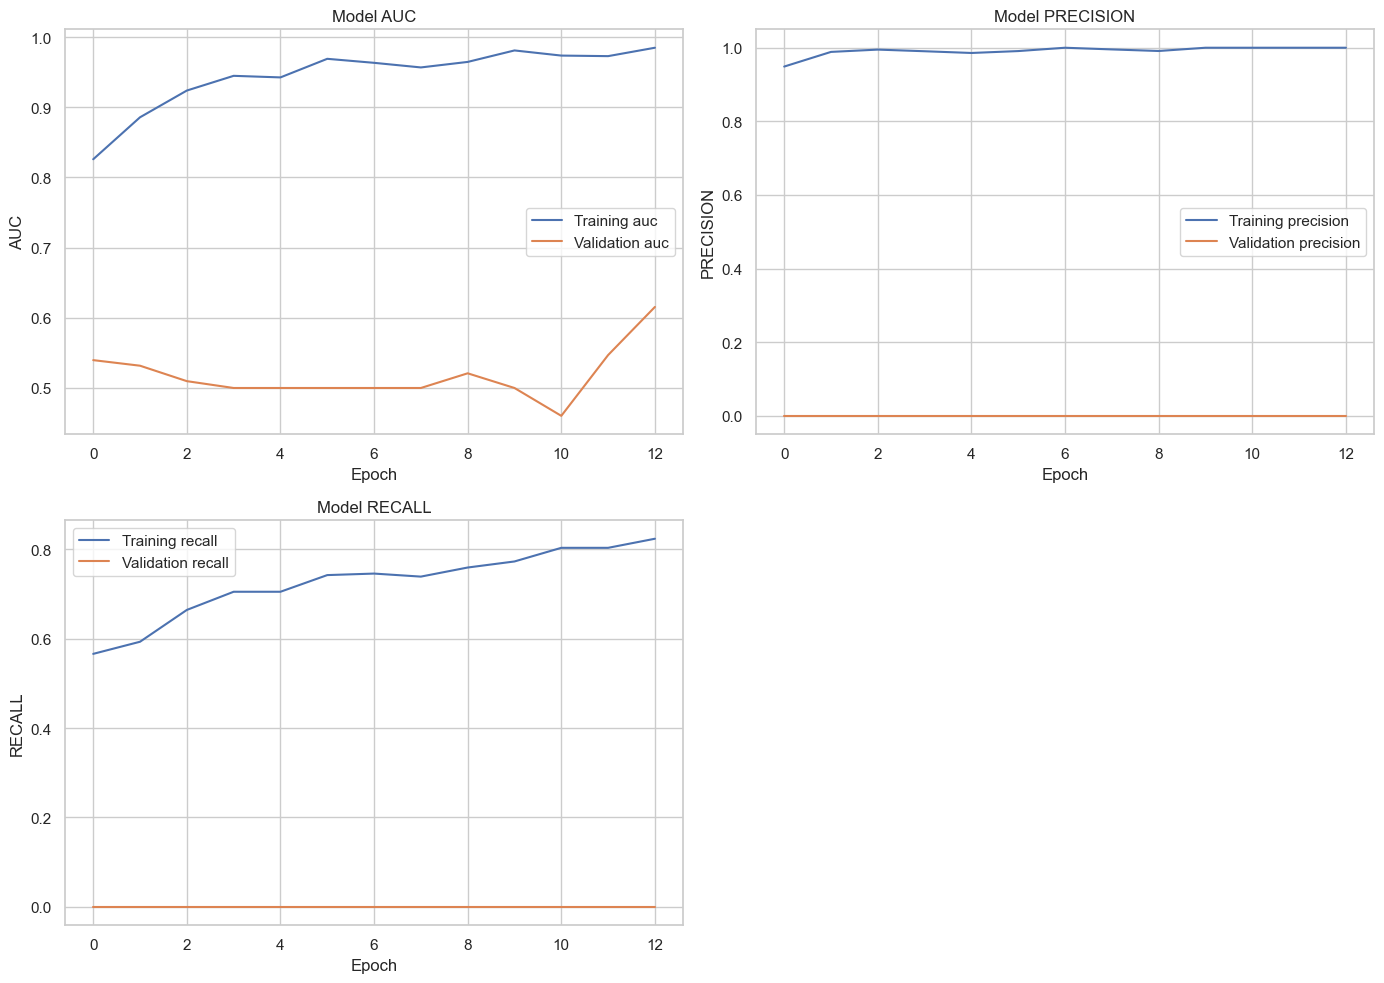

Final Training Metrics:
Training loss: 0.2242
Validation loss: 3.1198
Training accuracy: 0.8693
Validation accuracy: 0.2588
Training auc: 0.9847
Validation auc: 0.6154
Training precision: 1.0000
Validation precision: 0.0000
Training recall: 0.8237
Validation recall: 0.0000

Class Distribution in Training Set:
label
Positive    0.741206
Negative    0.258794
Name: proportion, dtype: float64

Class Distribution in Validation Set:
label
Positive    0.741176
Negative    0.258824
Name: proportion, dtype: float64

Class Distribution in Test Set:
label
Positive    0.744186
Negative    0.255814
Name: proportion, dtype: float64


In [ ]:
# --- Cell 3.4: Analyze Training and Create Visualizations ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from pathlib import Path


sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 5)


history_path = BASE_DIR / 'reports' / 'training_history.json'
with open(history_path, 'r') as f:
    history = json.load(f)


history_df = pd.DataFrame(history)


plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'training_history_plots.png', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(14, 10))
metrics = ['auc', 'precision', 'recall']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    if metric in history_df.columns:
        plt.plot(history_df[metric], label=f'Training {metric}')
        val_metric = f'val_{metric}'
        if val_metric in history_df.columns:
            plt.plot(history_df[val_metric], label=f'Validation {metric}')
        plt.title(f'Model {metric.upper()}')
        plt.ylabel(metric.upper())
        plt.xlabel('Epoch')
        plt.legend()

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()


print("Final Training Metrics:")
for metric in ['loss', 'accuracy', 'auc', 'precision', 'recall']:
    if metric in history_df.columns:
        print(f"Training {metric}: {history_df[metric].iloc[-1]:.4f}")
    val_metric = f'val_{metric}'
    if val_metric in history_df.columns:
        print(f"Validation {metric}: {history_df[val_metric].iloc[-1]:.4f}")


print("\nClass Distribution in Training Set:")
print(train_df['label'].value_counts(normalize=True))

print("\nClass Distribution in Validation Set:")
print(val_df['label'].value_counts(normalize=True))

print("\nClass Distribution in Test Set:")
print(test_df['label'].value_counts(normalize=True))

In [ ]:
# --- Cell 3.5: Evaluate on Test Set ---
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np


from tensorflow.keras.models import load_model
best_model_path = BASE_DIR / 'models' / 'baseline_model_best.h5'
model = load_model(best_model_path)


print("Evaluating on test set...")
test_metrics = model.evaluate(test_generator, verbose=1)
test_metrics = dict(zip(model.metrics_names, test_metrics))

print("\nTest Set Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")


test_generator.reset()
y_pred_proba = model.predict(test_generator)
y_pred = (y_pred_proba > 0.5).astype(int)


y_true = test_generator.classes


print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAnalysis complete! Check the generated plots in the reports/figures directory.")

In [ ]:
# --- Cell 3.7: Transfer Learning with ResNet50 (Updated) ---
import os
import ssl
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


original_ssl_context = ssl._create_default_https_context
ssl._create_default_https_context = ssl._create_unverified_context

try:
    
    def create_resnet_generator(datagen, df, batch_size=32, shuffle=True):
        return datagen.flow_from_dataframe(
            df,
            x_col='image_path',
            y_col='label',
            target_size=(224, 224),
            batch_size=batch_size,
            class_mode='binary',
            shuffle=shuffle,
            seed=42
        )

   
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    
    print("Creating data generators with ResNet50 preprocessing...")
    train_generator = create_resnet_generator(train_datagen, train_df)
    val_generator = create_resnet_generator(test_datagen, val_df, shuffle=False)
    test_generator = create_resnet_generator(test_datagen, test_df, shuffle=False)

 
    print("Loading ResNet50 with pre-trained ImageNet weights...")
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg'
    )

 
    base_model.trainable = False

    
    print("Building model...")
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    # Display model architecture
    model.summary()

    # Create models directory if it doesn't exist
    models_dir = BASE_DIR / 'models'
    models_dir.mkdir(exist_ok=True, parents=True)

    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            str(models_dir / 'resnet50_best.h5'),
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        tf.keras.callbacks.CSVLogger(
            str(BASE_DIR / 'reports' / 'resnet50_training_log.csv')
        )
    ]

    # Train the model
    print("\nTraining ResNet50 model...")
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        epochs=50,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    # Save the final model
    final_model_path = models_dir / 'resnet50_final.h5'
    model.save(str(final_model_path))
    print(f"\nTraining complete. Final model saved to {final_model_path}")

    # Save training history
    history_path = BASE_DIR / 'reports' / 'resnet50_training_history.json'
    with open(history_path, 'w') as f:
        json.dump(history.history, f, indent=2)
    print(f"Training history saved to {history_path}")

except Exception as e:
    print(f"An error occurred: {str(e)}")
    raise
finally:
    
    ssl._create_default_https_context = original_ssl_context

Creating data generators with ResNet50 preprocessing...
Found 398 validated image filenames belonging to 2 classes.
Found 85 validated image filenames belonging to 2 classes.
Found 86 validated image filenames belonging to 2 classes.
Loading ResNet50 with pre-trained ImageNet weights...
Building model...


Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)


Training ResNet50 model...
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.7514 - auc: 0.8571 - loss: 0.5196 - precision: 0.9300 - recall: 0.7183
Epoch 1: val_accuracy improved from None to 0.80000, saving model to /Applications/Projects/Sickle Cell Classifer/models/resnet50_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8417 - auc: 0.9630 - loss: 0.3452 - precision: 0.9793 - recall: 0.8034 - val_accuracy: 0.8000 - val_auc: 1.0000 - val_loss: 0.3904 - val_precision: 1.0000 - val_recall: 0.7302 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9219 - auc: 0.9926 - loss: 0.1724 - precision: 0.9978 - recall: 0.8988
Epoch 2: val_accuracy improved from 0.80000 to 1.00000, saving model to /Applications/Projects/Sickle Cell Classifer/models/resnet50_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 625ms/step - accuracy: 0.9196 - auc: 0.9899 - loss: 0.1834 - precision: 0.9962 - recall: 0.8949 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0105 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.9434 - auc: 0.9967 - loss: 0.1137 - precision: 1.0000 - recall: 0.9222
Epoch 3: val_accuracy did not improve from 1.00000
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 592ms/step - accuracy: 0.9196 - auc: 0.9959 - loss: 0.1392 - precision: 1.0000 - recall: 0.8915 - val_accuracy: 0.9882 - val_auc: 1.0000 - val_loss: 0.0485 - val_precision: 1.0000 - val_recall: 0.9841 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9500 - auc: 0.9972 - loss: 0.1163 - precision: 0.9969 - recall: 0.9384
Epoch 4: val_accuracy did not improve from 1.00000
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 604ms/step - accuracy: 0.9523 - auc: 0.9967 - loss: 0.1005 - precision: 0.9964 - rec


Training complete! Final model saved to /Applications/Projects/Sickle Cell Classifer/models/resnet50_final.h5
Training history saved to /Applications/Projects/Sickle Cell Classifer/reports/resnet50_training_history.json


Evaluating on test set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 891ms/step - accuracy: 0.9767 - auc: 0.9801 - loss: 0.2179 - precision: 1.0000 - recall: 0.9688

Test Set Metrics:
loss: 0.2179
compile_metrics: 0.9767
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step  

Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96        22
    Positive       1.00      0.97      0.98        64

    accuracy                           0.98        86
   macro avg       0.96      0.98      0.97        86
weighted avg       0.98      0.98      0.98        86



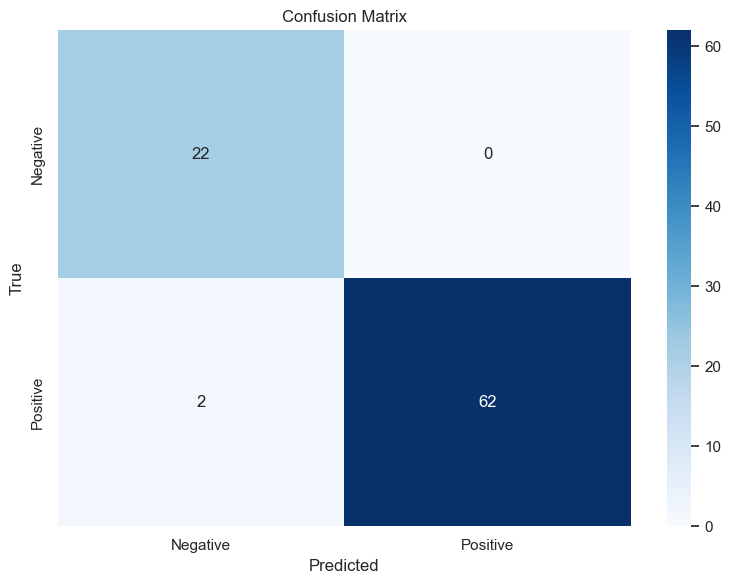

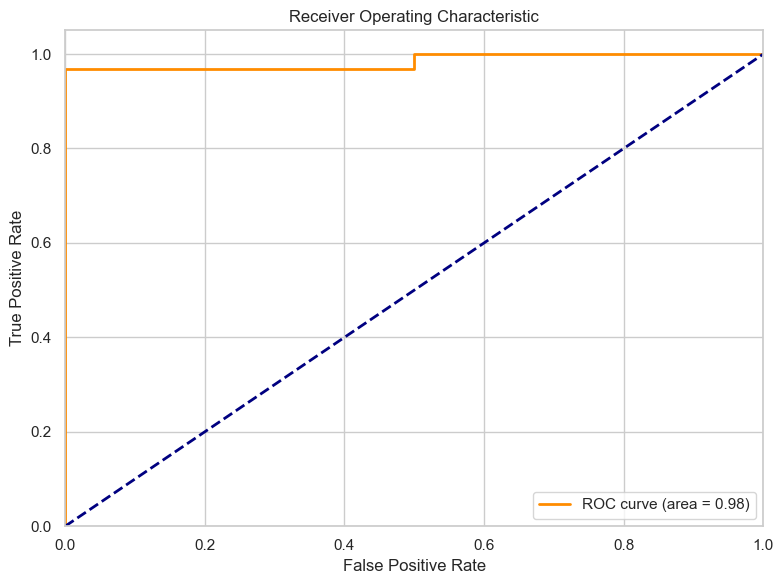

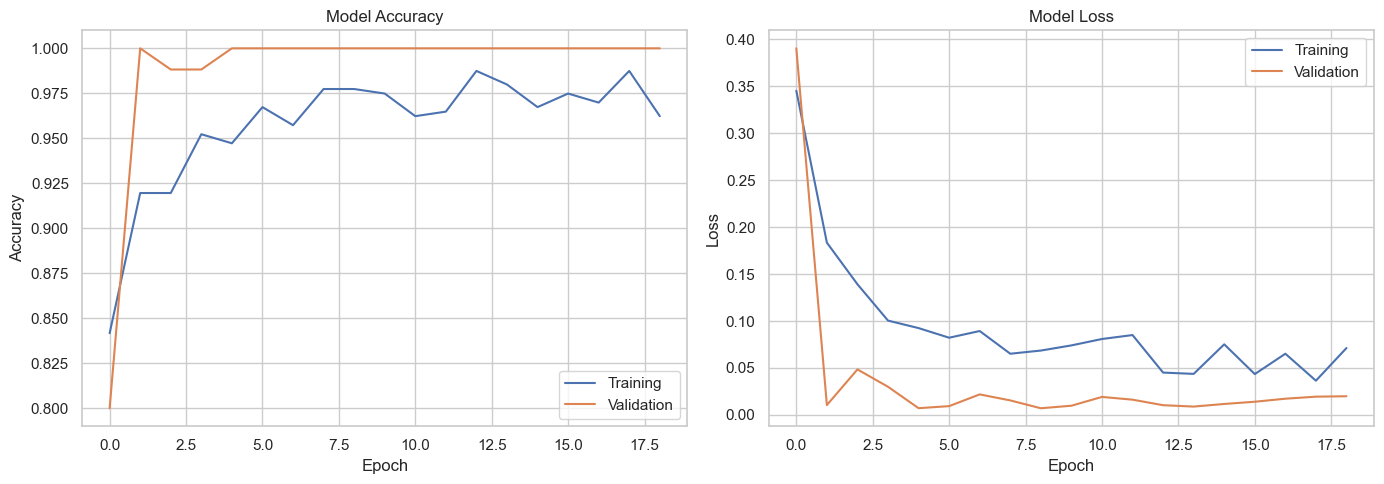

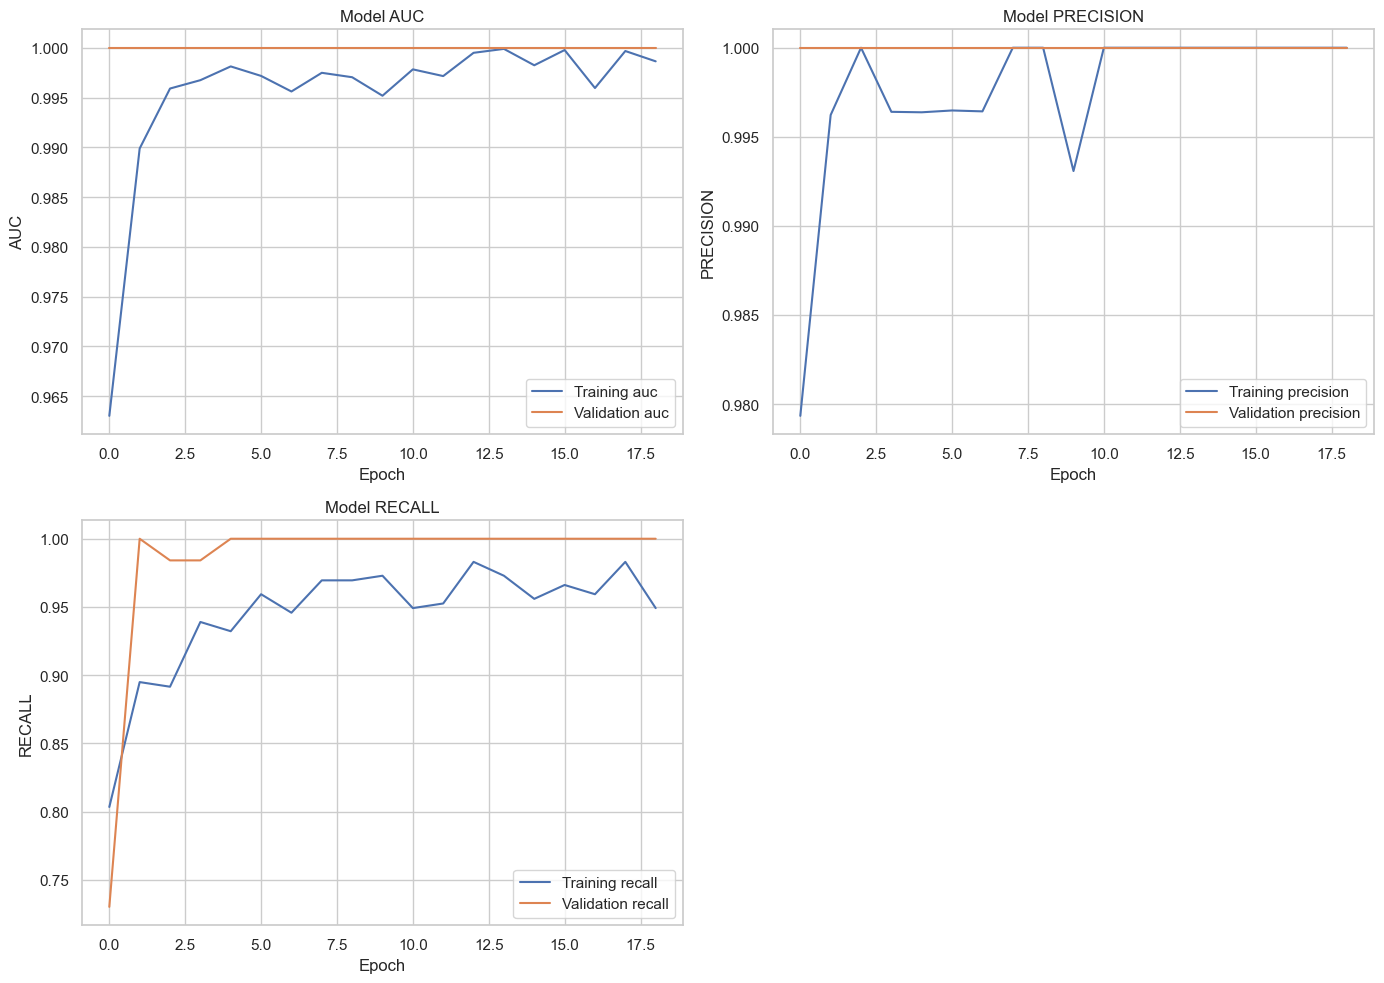


Evaluation complete! Check the generated plots in the reports/figures directory.


In [ ]:
# --- Cell 3.8: Evaluate ResNet50 on Test Set ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
best_model_path = BASE_DIR / 'models' / 'resnet50_best.h5'
model = tf.keras.models.load_model(best_model_path)


print("Evaluating on test set...")
test_metrics = model.evaluate(test_generator, verbose=1)
test_metrics = dict(zip(model.metrics_names, test_metrics))

print("\nTest Set Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")


test_generator.reset()
y_pred_proba = model.predict(test_generator)
y_pred = (y_pred_proba > 0.5).astype(int)


y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'resnet50_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'resnet50_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()


try:
    history_path = BASE_DIR / 'reports' / 'resnet50_training_history.json'
    with open(history_path, 'r') as f:
        history = json.load(f)
    

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'resnet50_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

   
    metrics = ['auc', 'precision', 'recall']
    plt.figure(figsize=(14, 10))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        if metric in history:
            plt.plot(history[metric], label=f'Training {metric}')
            val_metric = f'val_{metric}'
            if val_metric in history:
                plt.plot(history[val_metric], label=f'Validation {metric}')
            plt.title(f'Model {metric.upper()}')
            plt.ylabel(metric.upper())
            plt.xlabel('Epoch')
            plt.legend()
    
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'resnet50_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"Error plotting training history: {e}")

print("\nEvaluation complete. Check the generated plots in the reports directory.")